This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

'/media/cjw/PythonLib/cjwdeeplearning/autoencoder/Channels_0_1_3_4'

In [2]:
datadir1 = '/media/cjw/Data/cyto/mmFromTifs3/'
datadir2 = '/media/cjw/Data/cyto/mmNoComp/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

cp_dir1 = "/media/cjw/Data/cyto/Checkpoints/2018-04-18-Chs-0-1-3-4_32_mmFromTifs3/checkpoint-2018-04-18-16-56-46/"
aemeta1 = 'autoencoder-256x-27960.meta'

cp_dir2 = '/media/cjw/Data/FromAWS/cyto/Checkpoints/2018-04-20-Chs-0-1-3-4_32_mmNoComp/checkpoint-2018-04-20-14-51-35/'
aemeta2 = 'autoencoder-256x-27960.meta'
    
cpmeta1 = cp_dir1 + aemeta1
cpmeta2 = cp_dir2 + aemeta2

if os.path.exists(cpmeta1):
    print("meta 1 exists OK")
if os.path.exists(cpmeta2):
    print("meta 2 exists OK")

meta 1 exists OK
meta 2 exists OK


In [3]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
p_width = 32
p_height = 32
p_nchannels = 4
p_channels = [0,1,3,4]
p_nepochs = 120
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 256
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(128, 3), (256, 3), (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

params = dict()

params['width'] = p_width
params['height'] = p_height
params['nchannels'] = p_nchannels
params['channels'] = p_channels
params['nepochs'] = p_nepochs
params['batchsize'] = p_batchsize
params['learning_rate'] = p_learning_rate
params['restore'] = p_restore
params['latent_size'] = p_latent_size
params['droprate'] = p_droprate
params['stdev'] = p_stdev

params['enc_sizes'] = enc_sizes
params['dec_sizes'] = dec_sizes


In [4]:

def create_network(params, cp_dir, cpmeta,sess):
    images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
    z = tf.placeholder(tf.float32, (None, p_latent_size))

    enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                          nfilters=enc_sizes)
    sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                          is_train=False, nfilters=dec_sizes)

    loss, _, _ = network.ae_loss(images, sdd)

    opt = network.model_opt(loss, p_learning_rate)

    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(cpmeta)
    saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))
    return images, z, enc, sdd, loss, saver
 
tf.reset_default_graph()
sess = tf.Session()

images, z, enc, sdd, loss, saver = create_network(params, cp_dir1,cpmeta1, sess)



Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 4) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 4, 4, 512) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 256), dtype=float32)
isize:  4 32
dh0 (?, 32, 32, 4)
[<tf.Tensor 'Maximum_3:0' shape=(?, 8192) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 512) dtype=float32>, <tf.Tensor 'Maximum_4:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 16, 16, 128) dtype=float32>] Tensor("Minimum:0", shape=(?, 32, 32, 4), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/2018-04-18-Chs-0-1-3-4_32_mmFromTifs3/checkpoint-2018-04-18-16-56-46/autoencoder-256x-27960


In [5]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"

def create_mmdict(datadir):
    mmfiles = utils.list_mmfiles(datadir)
    print(mmfiles)
    mmdict = dict()
    n_all_images = 0
    for mmfilename in mmfiles:
        mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                        shape=(4,))

        header_shape = mmheader.shape
        print(header_shape, mmheader)
        xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
        xshape = tuple(xshape)
        del mmheader
        n_all_images += xshape[0]

        m3 = np.memmap(mmfilename, dtype='float32', offset=128,
                  mode='r', shape=xshape)
        key = mmfilename.split("/")[-1]
        mmdict[key] = m3

    print(n_all_images)
    print(mmdict.keys())
    return mmdict
    
mmdict1 = create_mmdict(datadir1)
mmdict2 = create_mmdict(datadir2)


['/media/cjw/Data/cyto/mmFromTifs3/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_CCB.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000
dict_keys(['Fish6_Untreated.mm', 'Fish6_ICE.mm', 'Fish6_CCB.mm'])
['/media/cjw/Data/cyto/mmNoComp/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmNoComp/Fish6_CCB.mm', '/media/cjw/Data/cyto/mmNoComp/Fish6_untreated.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000
dict_keys(['Fish6_ICE.mm', 'Fish6_CCB.mm', 'Fish6_untreated.mm'])


In [29]:
mmdict = mmdict2
xshapes= [mmdict[x].shape for x in mmdict.keys()]
n_all_images = np.sum(np.array(xshapes).T[0])
n_all_images

30000

In [30]:
""" Create the dataframe to go with the images"""


#n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
keys = sorted(list(mmdict.keys()))
for key in keys:
    mm = mmdict[key]
    n = mm.shape[0]
    print(key, n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf
df = df.reset_index()
print(len(df))
df.tail()

Fish6_CCB.mm 10000
Fish6_ICE.mm 10000
Fish6_untreated.mm 10000
30000


,index,column,fid,field,file,id,mmfile,plate,row,well,xc,yc,treatment,run
29995,29995,0,9995,0,Fish6_untreated,29995,Fish6_untreated.mm,0,0,0,32,32,untreated,Fish6
29996,29996,0,9996,0,Fish6_untreated,29996,Fish6_untreated.mm,0,0,0,32,32,untreated,Fish6
29997,29997,0,9997,0,Fish6_untreated,29997,Fish6_untreated.mm,0,0,0,32,32,untreated,Fish6
29998,29998,0,9998,0,Fish6_untreated,29998,Fish6_untreated.mm,0,0,0,32,32,untreated,Fish6
29999,29999,0,9999,0,Fish6_untreated,29999,Fish6_untreated.mm,0,0,0,32,32,untreated,Fish6


In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

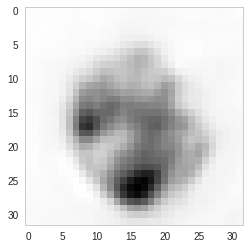

In [32]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
plt.imshow(xdd[123,:,:,1])

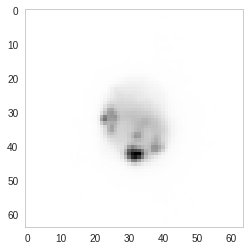

In [33]:

ix = mmdict[keys[0]]
plt.imshow(ix[123,:,:,1])

In [34]:
try:
    os.makedirs('/media/cjw/Data/cyto/decodedImages/')
except:
    print("whoops")
outfile = '/media/cjw/Data/cyto/decodedImages/set2.mm'
mxdd = np.memmap(outfile, dtype=np.float32, offset=0,
                   mode='w+', shape=(30000, 32, 32, 4))

mxdd[:, :, :, :] = xdd
mxdd.flush
del mxdd

whoops


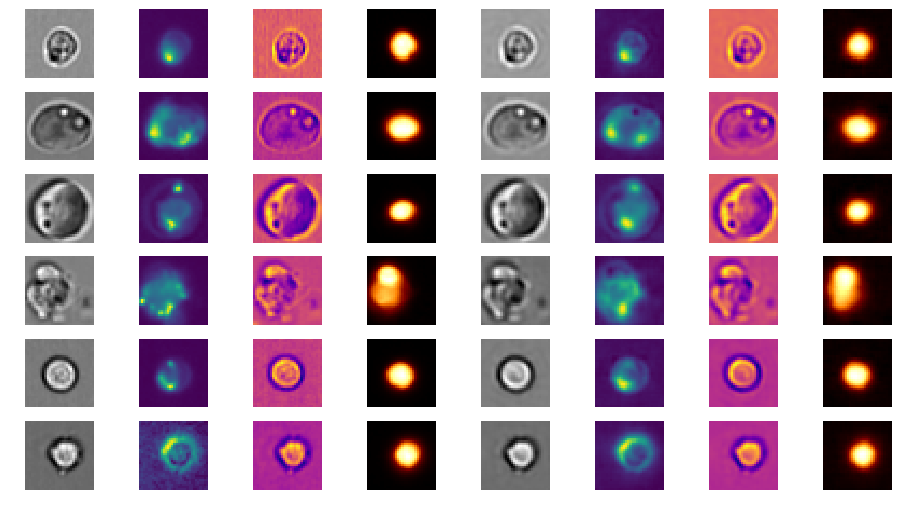

In [8]:
def one_imshow(image, r, c, ic, cmap):
    plt.subplot(16, 8, ic)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')

ic = 1

nrows = 6
plt.figure(figsize=(16,4*nrows))

for i in range(nrows):
    ix = np.random.randint(0, len(vv))
    one_imshow(vv[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(vv[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(vv[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(vv[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1
    
    one_imshow(xdd[ix,:,:,0], nrows, 8, ic, 'gray')
    ic += 1
    
    one_imshow(xdd[ix,:,:,1], nrows, 8, ic, 'viridis')
    ic += 1
    
    one_imshow(xdd[ix,:,:,2], nrows, 8, ic, 'plasma')
    ic += 1
    
    one_imshow(xdd[ix,:,:,3], nrows, 8, ic, 'afmhot')
    ic += 1

plt.savefig('/media/cjw/Data/cyto/output/decoded.png')

In [9]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
3000
hek (3000, 256)
0 0 (3000, 256) (3000, 256)


(3000, 256)

In [10]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.] 10


-------------------------------------------------------------------------